## Process One 256x256 Image

This Jupyter notebook demonstrates how to utilize a trained model and process a new input transmitted-light input image using the saved weights. 

To keep this demo code simplistic, we expect an input image of size 256 by 256 pixels^2. To see how to process large images in a sliding-window fashion, reference the code in the folder named "7_Process_New_Image". 

1. Define user input, including input/output paths, and experimental details (cell type, features, etc.).

In [1]:

# Path to 256x256 input image: 
input_image = './dic_input_0000.tif'

# Path to weights file (.h5): 
weights_file = './nonorm_mdck_20x_dapi_1stack_unet_mse.h5'

# Define your experimental conditions, to reference normalization statistics for this condition: 
# Options: 'MDCK', 'KC', 'HUVECS_256'
cell_type = 'MDCK'
# Options: '5x', '10x', '20x'
magnification = '20x'
# Options: 'DAPI', 'RFP', 'YFP', 'CY5'
output_var = 'DAPI'

# Define model parameters: 
# Options: 'p', 'mse'
use_loss = 'mse'
# Options: '1stack', '2stack'
use_net = '1stack'


2. Get the relevant information for applying the model, including the model definition and weights. 

In [2]:
# Import libraries: 
import os
import sys
import random
import warnings
import numpy as np
from PIL import Image
from libtiff import TIFF

from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt

import keras
from keras import optimizers
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras import backend as K
import tensorflow as tf
# Our code: 
import utils
import models 

# ------------------------------------------------------------------

# Get data details including normalization statistics: 
IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS, out_dir, TRAIN_PATH, TEST_PATH, input_var, output_var, input_mean, input_stdev, output_mean, output_stdev = utils.get_normalization_factors(cell_type, magnification, output_var)

# Define model: 
if(use_net == '1stack'):
    model = models.get_unet_nonorm(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
if(use_net == '2stack'):
    model = models.get_2stack_unet_nonorm(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

# Get optimizer/loss:
adad = keras.optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0)
if(use_loss == 'p'):
    loss_func = utils.pear_corr
if(use_loss == 'mse'):
    loss_func = 'mean_squared_error'

# Compile the U-Net model
model.compile(loss=loss_func,
              optimizer=adad,
              metrics=['mse'])

# Load the model weights 
model.load_weights(weights_file, by_name=True)
# If desired, summarize the model: 
#model.summary()

Using TensorFlow backend.
W0827 12:32:37.009811 140485373789952 deprecation_wrapper.py:119] From /home/julienne/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0827 12:32:37.022208 140485373789952 deprecation_wrapper.py:119] From /home/julienne/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0827 12:32:37.025071 140485373789952 deprecation_wrapper.py:119] From /home/julienne/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0827 12:32:37.038096 140485373789952 deprecation_wrapper.py:119] From /home/julienne/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is 

3. Process the input image.

In [3]:
# Set this option just in case we need to handle an unusual TIFF format:
Image.MAX_IMAGE_PIXELS = None

# Read in image file:
img = np.array(Image.open(input_image))

# Normalize the image using statistics from training set: 
img = (img - input_mean)/(input_stdev)

# Process each input image: 
imgarr = np.expand_dims(np.expand_dims(img, axis=0), axis=3)
prediction = model.predict(imgarr, verbose=0)[0,:,:,0]

# Normalize the output image using statistics from training set: 
prediction = (prediction * output_stdev) + output_mean

# Convert output image to 16-bit type:
prediction = prediction.clip(min=0.0)
prediction = prediction.astype('uint16')
        

4. Save the image. We'll also display it here, but it doesn't look good in Jupyter notebook format! 

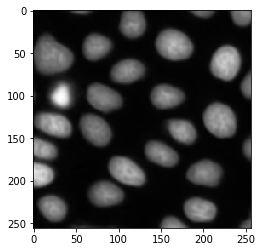

In [4]:

plt.imshow(prediction, cmap='gray')
plt.show()

save_name = './predicted_image_0.tif'

tiff = TIFF.open(save_name, mode='w')
tiff.write_image(prediction)
tiff.close()